## Example of usage of Smana
Use this notebook to test some features of smana!
In particular these snippets let you build a custom dataset, specifying time resolution and setting missing data periods, and restore it by means of the main method of the package `smana.repair()`.

### Import smana and configure the example
In the first step you can configure the construction process of the starting dataset, by setting:
- `n_components_in_a_day` (*integer*): the number of data points for a single day (for example, set it to 24 to get hourly data or 96 to get quarter-hourly data; note that `smana` supports any sub-daily resolution);
- `first_date_string`, `last_date_string` (*string, format “%Y-%m-%d”*): boundaries of the calendar period to consider;
- `missing_periods_list` (*list of tuples, each tuple is composed of two strings with format “%Y-%m-%d %H:%M”*): list of periods with missing data, each tuple represents the first and last datetime of a continuous sequence of missing data (the two timestamps can coincide, in order to simulate a single missing record).

In [1]:
import smana as smn
import numpy as np
import pandas as pd
from datetime import datetime as dt, timedelta
import random

n_components_in_a_day = 24
first_date_string = "2023-03-15"  # date format: %Y-%m-%d
last_date_string = "2023-05-26"
missing_periods_list = [
    ("2023-03-17 05:00", "2023-03-17 22:00"),
    ("2023-03-21 17:00", "2023-03-23 12:00"),
    ("2023-04-15 09:00", "2023-04-24 12:00"),
    ("2023-05-17 21:00", "2023-05-19 03:00")
]  # date format: %Y-%m-%d %H:%M


### Build dataset
In this section, the dataframe is built: the list of timestamps is used as index, the numeric column to be restored (`scan_column`) is generated starting from a noisy trend (`raw_trend`) and adding a noisy weekly seasonality (`scan_column`) which simulates a typical energy data pattern; then, periods with missing data are created. The output of the current cell is the plot of the time series to be restored.

<AxesSubplot: xlabel='timestamp_start'>

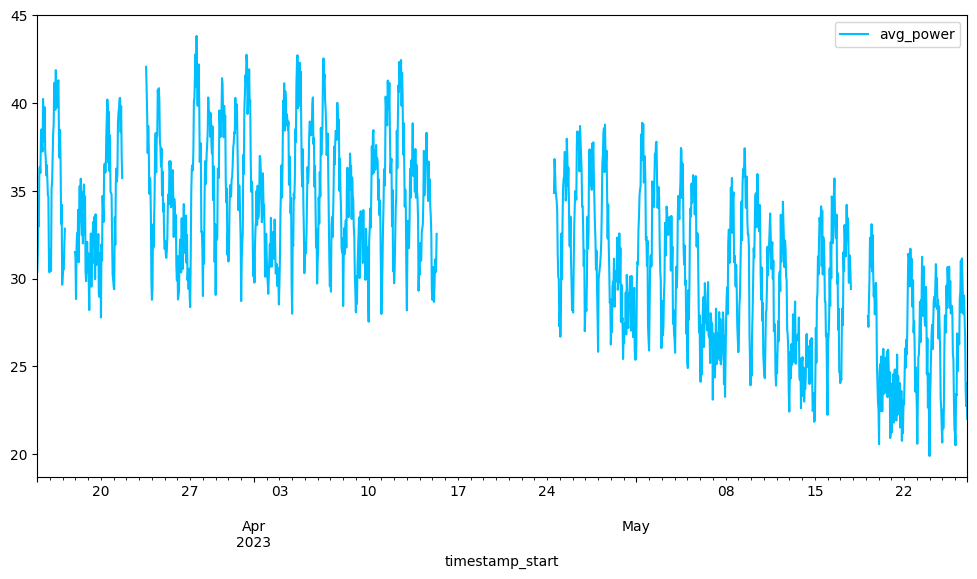

In [2]:
scan_column = 'avg_power'
datetime_column = 'timestamp_start'
cur_secs_resolution = int(3600 * 24 / n_components_in_a_day)

n_components_in_a_week = 7 * n_components_in_a_day
starting_date = dt.strptime(first_date_string, "%Y-%m-%d")
first_week_id = starting_date.isocalendar()[1]
ending_date = dt.strptime(last_date_string, "%Y-%m-%d") + timedelta(days=1)

list_datetime = pd.date_range(start=starting_date, end=ending_date, freq=f'{cur_secs_resolution}s', inclusive="left")
dates_to_generate = pd.date_range(start=starting_date, end=ending_date, freq=f'D', inclusive="left")
df_periodic = pd.DataFrame(list_datetime, columns=[datetime_column])
df_periodic.set_index(keys=datetime_column, drop=True, inplace=True)

n_days = 1 + int((ending_date - starting_date).total_seconds() / timedelta(days=1).total_seconds())
# Define starting trend
raw_trend = 20.0 + 5.0 * np.array(
    [np.sin((first_week_id * n_components_in_a_week + x) * 2 * np.pi / (n_components_in_a_week * 52)
            ) - np.cos(2.0 * (first_week_id * n_components_in_a_week + x) * 2 * np.pi / (n_components_in_a_week * 52)
                       ) for x in range(n_components_in_a_day * n_days)])
# Add noise to raw_trend
raw_trend += -2.0 + 4.0 * np.random.rand(raw_trend.shape[0])

# Build seasonal pattern
seasonal_component = []
drift = 0
for curr_date in dates_to_generate:
    curr_weekday = curr_date.weekday()
    if curr_weekday < 5:  # daily profile for working days
        daily_factor = random.uniform(8.0, 12.0)
        seasonal_component.extend([
            drift + daily_factor * np.sin(x * np.pi / n_components_in_a_day) for x in range(n_components_in_a_day)])
    elif curr_weekday == 5:  # daily profile for Saturday
        saturday_factor = random.uniform(3.0, 6.0)
        seasonal_component.extend([
            drift + saturday_factor * np.sin(x * np.pi / n_components_in_a_day) for x in range(n_components_in_a_day)])
    else:  # daily profile for Sunday
        sunday_factor = random.uniform(2.0, 3.0)
        seasonal_component.extend([
            drift + sunday_factor * np.sin(x * np.pi / n_components_in_a_day) for x in range(n_components_in_a_day)])

seasonal_component = np.array(seasonal_component)
df_periodic['raw_trend'] = pd.Series(raw_trend[:len(df_periodic)], index=df_periodic.index)
df_periodic['seasonal'] = pd.Series(seasonal_component[:len(df_periodic)], index=df_periodic.index)
df_periodic[scan_column] = df_periodic['raw_trend'] + df_periodic['seasonal']

# Create missing data periods
for cur_period in missing_periods_list:
    df_periodic.loc[(df_periodic.index >= dt.strptime(cur_period[0], "%Y-%m-%d %H:%M")
                     ) & (df_periodic.index <= dt.strptime(cur_period[1], "%Y-%m-%d %H:%M")), scan_column] = np.nan

# Plot dataframe
df_periodic.plot(y=scan_column, figsize=(12, 6), color='deepskyblue')

### Restore and plot new data
To restore data, you just need to call the method `smana.repair()`, specifying the input dataframe and the name of the numeric column that you want to repair. Restored values are then emphasized with red color in the last plot.

<AxesSubplot: xlabel='timestamp_start'>

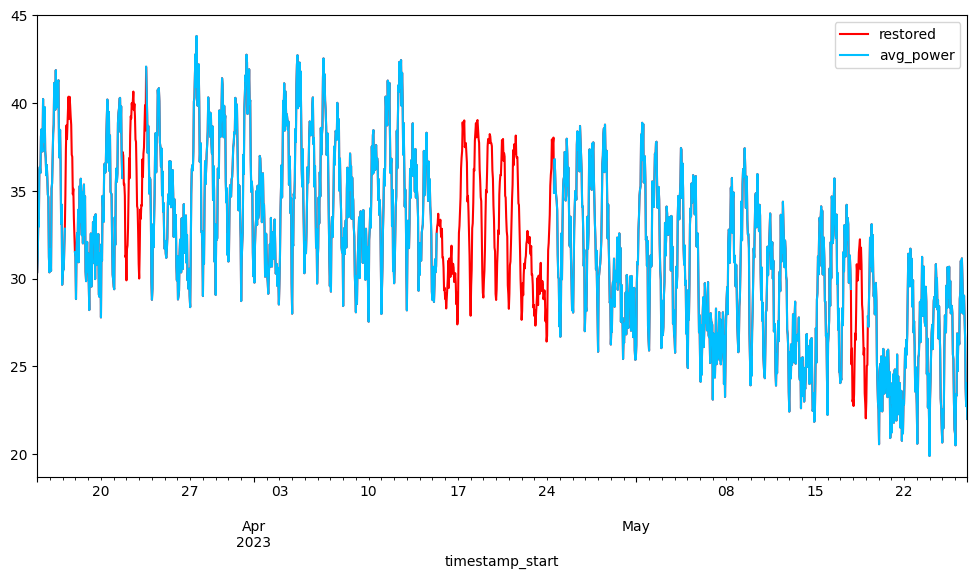

In [3]:
new_data = smn.repair(input_df=df_periodic, scan_column=scan_column, inplace=False)
new_data.rename(columns={scan_column: 'restored'}, inplace=True)
new_data.loc[new_data.index.isin(df_periodic[df_periodic[scan_column].notna()].index), scan_column] = np.nan
ax = new_data.plot(y='restored', color='red', figsize=(12, 6))
df_periodic.plot(y=scan_column, color='deepskyblue', ax=ax)